<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [173]:
import itertools
import numpy as np
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import linear_model

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

import warnings 

%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [174]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-06-09 13:38:00--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.006s  

2019-06-09 13:38:00 (3.73 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [175]:
df = pd.read_csv('loan_train.csv')
df = df[df.columns[~df.columns.str.contains('Unnamed:')]]
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [176]:
df.shape

(346, 8)

### Convert to date time object 

In [177]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [178]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [179]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

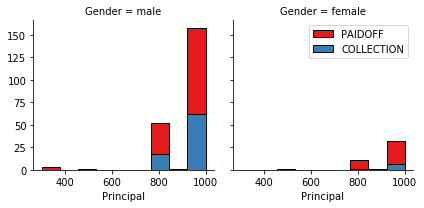

In [180]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

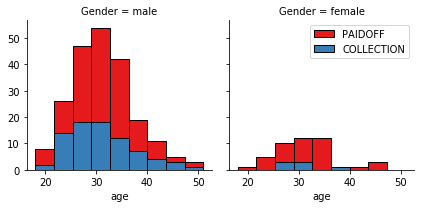

In [181]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

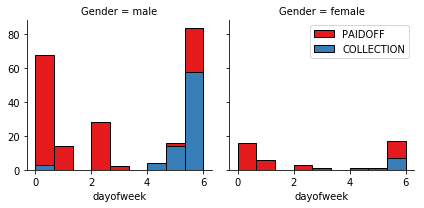

In [182]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [183]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [184]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [185]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [186]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [187]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [188]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [189]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [190]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [191]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [192]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.15, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (294, 8) (294,)
Test set: (52, 8) (52,)


In [193]:
Ks = 100
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc[:5]

array([ 0.67307692,  0.63461538,  0.69230769,  0.67307692,  0.73076923])

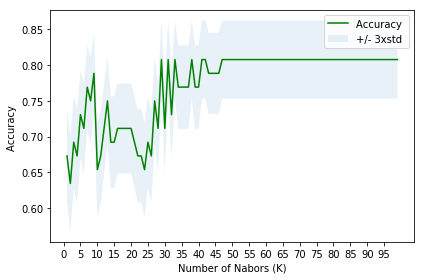

In [194]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.xticks(np.arange(0, 100, 5))
plt.tight_layout()
plt.show()

In [195]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.807692307692 with k= 29


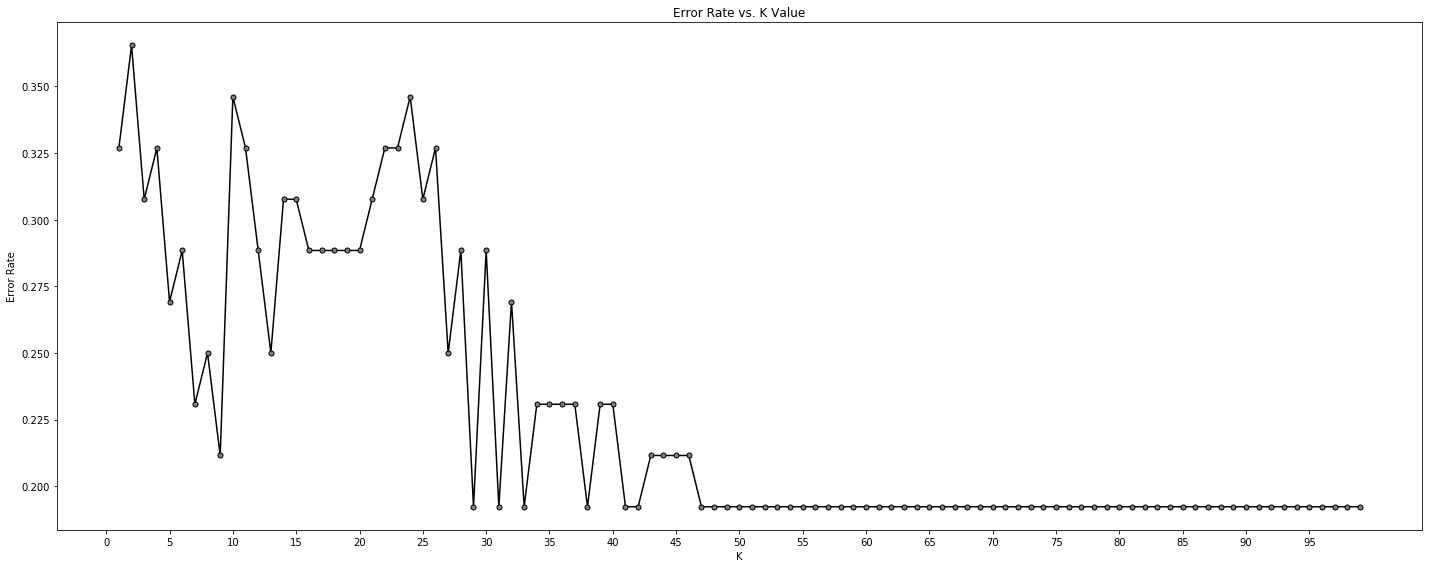

In [196]:
error_rate = []

for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
 
plt.figure(figsize=(20,8))
plt.plot(range(1,100),error_rate,color='black',marker='o',markerfacecolor='gray', markersize=5)
plt.xticks(np.arange(0, 100, 5))
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.tight_layout()
plt.show()

**By looking at the accuracy and error rate, the model achieves best accuracy and lowest error rate when seting k=29.**

In [197]:
knn_tuned = KNeighborsClassifier(n_neighbors = 29).fit(X_train,y_train)
knn_pred = knn_tuned.predict(X_test)
knn_pred[:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

# Decision Tree

In [198]:
Ks = 100
mean_acc = np.zeros((Ks-1))

for depth in range(1,Ks):
    #Train Model and Predict  
    tree = DecisionTreeClassifier(criterion="entropy", max_depth = depth)
    tree.fit(X_train,y_train)
    predTree = tree.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, predTree)

mean_acc[:5]

array([ 0.,  0.,  0.,  0.,  0.])

In [199]:
mean_acc = []
for depth in range(1,100):
    for split in range(2,10):
        #Train Model and Predict  
        tree = DecisionTreeClassifier(criterion="entropy", max_depth = depth, min_samples_split = split)
        tree.fit(X_train,y_train)
        predTree = tree.predict(X_test)
        mean_acc.append(metrics.accuracy_score(y_test, predTree))
    
mean_acc[:5]

[0.80769230769230771,
 0.80769230769230771,
 0.80769230769230771,
 0.80769230769230771,
 0.80769230769230771]

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:    1.0s finished


Best: -0.640906 using {'min_samples_split': 2, 'max_depth': 2}
-0.640906 (0.449008) with: {'min_samples_split': 2, 'max_depth': 2}
-0.640906 (0.449008) with: {'min_samples_split': 3, 'max_depth': 2}
-0.640906 (0.449008) with: {'min_samples_split': 4, 'max_depth': 2}
-0.640906 (0.449008) with: {'min_samples_split': 5, 'max_depth': 2}
-0.640906 (0.449008) with: {'min_samples_split': 6, 'max_depth': 2}
-0.640906 (0.449008) with: {'min_samples_split': 7, 'max_depth': 2}
-0.640906 (0.449008) with: {'min_samples_split': 8, 'max_depth': 2}
-0.640906 (0.449008) with: {'min_samples_split': 9, 'max_depth': 2}
-0.649908 (0.454699) with: {'min_samples_split': 2, 'max_depth': 3}
-0.649908 (0.454699) with: {'min_samples_split': 3, 'max_depth': 3}
-0.649908 (0.454699) with: {'min_samples_split': 4, 'max_depth': 3}
-0.649908 (0.454699) with: {'min_samples_split': 5, 'max_depth': 3}
-0.649908 (0.454699) with: {'min_samples_split': 6, 'max_depth': 3}
-0.649908 (0.454699) with: {'min_samples_split': 7, '

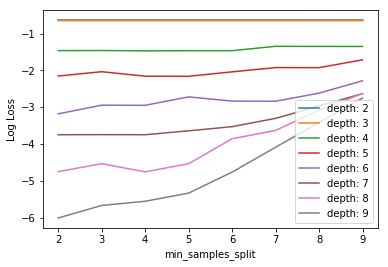

In [200]:
# grid search
model = DecisionTreeClassifier()
min_samples_split = range(2,10)
max_depth = range(2,10)
label_encoded_y_train = LabelEncoder().fit_transform(y_train)

param_grid = dict(max_depth=max_depth, min_samples_split=min_samples_split)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, label_encoded_y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(max_depth), len(min_samples_split))
for i, value in enumerate(max_depth):
    plt.plot(min_samples_split, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('min_samples_split')
plt.ylabel('Log Loss')
plt.show()

**The best result was achieved with a min_samples_split=2 and max_depth=2**

In [201]:
tree_tuned = DecisionTreeClassifier(criterion="entropy", min_samples_split = 2, max_depth = 2)
tree_tuned.fit(X_train,y_train)
tree_pred = tree_tuned.predict(X_test)
tree_pred[:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

# Support Vector Machine

In [202]:
kernel =['linear','rbf']
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50]
gammas = [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50]
class_weight = [None, 'balanced']

param_grid = {
    'kernel':kernel,
    'C': Cs, 
    'gamma' : gammas, 
    'class_weight' : class_weight
             }

svm_best_model = GridSearchCV(svm.SVC(), param_grid, cv=3)
svm_best_model.fit(X_train, y_train)
print ('Best parameter: {}\n'.format(svm_best_model.best_params_))
print ('Best accuracy validation data: {:.5f}\n'.format(svm_best_model.best_score_))
print ('Best accuracy validation data: {}\n'.format(svm_best_model.best_estimator_))

Best parameter: {'kernel': 'linear', 'gamma': 0.0001, 'class_weight': None, 'C': 0.0001}

Best accuracy validation data: 0.74150

Best accuracy validation data: SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)



In [203]:
svm_tuned = svm.SVC(kernel='linear',gamma=0.0001, class_weight=None, C=0.0001)
svm_tuned.fit(X_train, y_train) 
svm_pred = svm_tuned.predict(X_test)
svm_pred[:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

# Logistic Regression

In [204]:

penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
class_weight = [None, 'balanced']

hyperparameters = dict(C=C, penalty=penalty, class_weight=class_weight)

# Create grid search using 5-fold cross validation
lr_clf = GridSearchCV(linear_model.LogisticRegression(), hyperparameters, cv=5, verbose=0)

# Fit grid search
lr_best_model = lr_clf.fit(X_train, y_train)

print ('Best parameter: {}\n'.format(lr_best_model.best_params_))
print ('Best accuracy validation data: {:.5f}\n'.format(lr_best_model.best_score_))
print ('Best accuracy validation data: {}\n'.format(lr_best_model.best_estimator_))

Best parameter: {'penalty': 'l2', 'class_weight': None, 'C': 1.0}

Best accuracy validation data: 0.72449

Best accuracy validation data: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)



In [205]:
lr_tuned = linear_model.LogisticRegression(penalty='l2',C=1,class_weight=None)
lr_tuned.fit(X_train, y_train) 
lr_pred = lr_tuned.predict(X_test)
lr_pred[:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [206]:
# Get prob for each class for the Report df.
lr_pred_prob_prob = lr_tuned.predict_proba(X_test)
lr_pred_prob_prob[:5]

array([[ 0.51743815,  0.48256185],
       [ 0.39554173,  0.60445827],
       [ 0.0288069 ,  0.9711931 ],
       [ 0.03643971,  0.96356029],
       [ 0.02914278,  0.97085722]])

# Model Evaluation using Test set

In [207]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [208]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-06-09 13:38:12--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-06-09 13:38:12 (699 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [209]:
test_df = pd.read_csv('loan_test.csv')
test_df = test_df[test_df.columns[~test_df.columns.str.contains('Unnamed:')]]
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [210]:
jaccard_result = []
f1_result = []
models_preds = [knn_pred,tree_pred,svm_pred,lr_pred]

for model in models_preds:
    print(set(y_test) - set(model))

set()
{'COLLECTION'}
{'COLLECTION'}
set()


2 models didn't predict any test data as 'Collection,' thus the f-1 score function will return a warning and not display the result correctly. Thus we mute it.

In [211]:
warnings.filterwarnings('ignore') 

In [212]:
for model in models_preds:
    jaccard_result.append(jaccard_similarity_score(y_test, model))
    f1_result.append(f1_score(y_test, model, average='weighted') )

print(jaccard_result)
print()
print(f1_result)

[0.80769230769230771, 0.80769230769230771, 0.80769230769230771, 0.76923076923076927]

[0.75195094760312142, 0.72176759410801961, 0.72176759410801961, 0.74562937062937062]


In [213]:
report_df = pd.DataFrame(columns=['Algorithm','Jaccard','F1-score','LogLoss'])
report_df['Algorithm'] = ['KNN','Decision Tree','SVM','LogisticRegression']
report_df['Jaccard'] = jaccard_result
report_df['F1-score'] = f1_result
report_df['LogLoss'] = ['NA','NA','NA',log_loss(y_test, lr_pred_prob_prob)]

report_df

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.807692,0.751951,NA
1,Decision Tree,0.807692,0.721768,NA
2,SVM,0.807692,0.721768,NA
3,LogisticRegression,0.769231,0.745629,0.507751


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>